In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import random
import math
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns

# ODE Layer

In [2]:
class LinearODELayer(nn.Module):
    def __init__(self, in_features, out_features, bias=False):
        super(LinearODELayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.Tensor(self.out_features, self.in_features))
        if bias:
            self.bias = nn.Parameter(torch.Tensor(self.out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()
    # the forward step
    def forward(self, x):
        output = x.mm(self.weight)
        if self.bias is not None:
            output += self.bias
        return output
    # the backward function is not necessary, sincewe have only used
    # functions from pytorch (in particular, .reshape and .mm)
    
    # this function is inherited from the pytorch class Linear
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)
            
#Thsi object can be extended
class NonLinearODELayer(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim):
        super(NonLinearODELayer, self).__init__()
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        self.weight = nn.Parameter(torch.Tensor(self.in_dim, self.hid_dim, self.out_dim))
        self.reset_parameters()
    
    def forward(self, x):
        xBx = x.matmul(self.weight).matmul(x.t()).permute(2,1,0)
        out = torch.diagonal(xBx).t()
        return out
    
    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

# ODE Model

In [3]:
class LinearODEModel(nn.Module):
    def __init__(self, in_feature, out_feature, bias=False):
        super(LinearODEModel, self).__init__()
        self.in_feature = in_feature
        self.out_feature = out_feature
        self.bias = bias
        self.ode = LinearODELayer(self.in_feature, self.out_feature, self.bias)
        
    def forward(self, x):
        out = self.ode(x)
        return out
    
    
class NNODEModel(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, bias=False):
        super(NNODEModel, self).__init__()
        #Dimension
        self.in_dim = in_dim
        self.hid_dim = hid_dim
        self.out_dim = out_dim
        
        self.bias = bias
        
        #Layer 
        self.lin_ode = LinearODELayer(self.in_dim, self.out_dim, self.bias)
        self.nl_ode = NonLinearODELayer(self.in_dim, self.hid_dim, self.out_dim)
        
        #weight init
        self.reset_parameters()
        
    def forward(self, x):
        out = self.lin_ode(x) + self.nl_ode(x)
        return out
    
    def reset_parameters(self):
        self.lin_ode.weight.data.uniform_(-0.1,0.1)
        if self.bias:
            self.lin_ode.bias.data.uniform_(-0.1,0.1)
        self.nl_ode.weight.data.uniform_(-0.01,0.01)

# Utils

In [87]:
def train_model(model, train_x, train_y, loss_fn, optimizer, batch_size):
    train_loss = 0
    for b in range(0, train_x.size(0), batch_size):
        model.zero_grad()
        pred = model(train_x.narrow(0, b, batch_size))
        loss = loss_fn(pred, train_y.narrow(0, b, batch_size))
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    return train_loss

def tensor_norm(tensor):
    a = tensor.view(-1)
    b = torch.norm(a, p=2)
    return b

def generate_pendulum(k, sol, dt=1, T=100, dim=2):
    A = np.asarray([[0,1],[-k,0]])
    I = np.eye(dim)
    AA = (I + dt*A)
    for i in range(T):
        sol.append(np.dot(np.asarray(sol[-1]),AA))
    
    X = np.asarray(sol)[:-1]
    Y = np.asarray(sol)[1:]
    train_x = torch.FloatTensor(X)
    train_y = torch.FloatTensor(Y)
    return train_x, train_y, torch.Tensor(AA)


def generate_lorenz(sigma, rho, beta, sol, dt=0.01, T=10000, dim=3):
    A = np.asarray([[-sigma, sigma, 0], [rho, -1, 0], [0, 0, -beta]])
    Q0 = np.asarray([[0,0,0], [0,0,0], [0,0,0]])*dt
    Q1= np.asarray([[0,0,-1], [0,0,0], [0,0,0]])*dt
    Q2 = np.asarray([[0,1,0],[0,0,0], [0,0,0]])*dt
    
    B = np.array([Q0, Q1, Q2])

    I = np.eye(dim)
    AA = (I+dt*A)
    
    for i in range(T):
        x = np.asarray(sol[-1])
        Ax = AA.dot(x)
    
        phix = x.T.dot(B).dot(x)
    
        f = Ax + phix
        sol.append(f)
    
    X = np.asarray(sol)[:-1]
    Y = np.asarray(sol)[1:]
    train_x = torch.FloatTensor(X)
    train_y = torch.FloatTensor(Y)
    
    return train_x, train_y, torch.Tensor(AA), torch.Tensor(B)

def training_session(model, train_x, train_y, lr=1e-2, n_print=10, n_epoch=100, batch_size=1, print_mat=False, print_feat=False):
    loss_fn = nn.MSELoss()
    optimizer = optim.Adagrad(model.parameters(), lr=lr)
    if print_mat:
        print('Initial weigths of the matrix:')
        print(list(model.parameters()))

    train_loss = []

    for epoch in range(n_epoch):
        loss = train_model(model, train_x, train_y, loss_fn, optimizer, batch_size)
        train_loss.append(loss)
        if print_feat:
            if epoch%n_print == 0:
                print('\n\n\nEpoch:', epoch+1, 'train_loss:', loss)
                print('weight:')
                print(list(model.parameters()))
    if print_mat:
        print('Final weigths of the matrix:')
        print(list(model.parameters()))
    weights = model.state_dict()
    lin_weight = weights['lin_ode.weight']
    nl_weight = weights['nl_ode.weight']
    if print_feat:
        plt.plot(train_loss)
        plt.show()
    return train_loss, lin_weight, nl_weight

def prediction(lin_weight, nl_weight, sol, T):
    lin_weight = np.array(lin_weight)
    nl_weight = np.array(nl_weight)
    for i in range(100):
        x = np.asarray(sol[-1])
        Ax = lin_weight.dot(x)
    
        phix = x.T.dot(nl_weight).dot(x)
    
        f = Ax + phix
        sol.append(f)
    return np.array(sol)

In [57]:
def grid_search(model, train_x, train_y, T, z_dim, H, B, n_sim=40, noise=[0.,0.1,0.2,0.3,0.4,0.5], epoch=[200, 500, 1000], batch_size=[10, 50, 100], lr=1e-2):
    results = []
    print('start simulation')
    for s in range(n_sim):
        print('simulation:', s+1)
        for std in noise:
            for e in epoch:
                for b in batch_size:
                    torch.manual_seed(s)
                    norm_noise = torch.randn(T, z_dim)*std
                    train_x_noise = train_x + norm_noise
                    train_y_noise = train_y + norm_noise

                    train_loss, _, _ = training_session(model, train_x_noise, train_y_noise, lr, 10, e, b)
                    weights = model.state_dict()
                    lin_weights = weights['lin_ode.weight'].detach().numpy().copy()
                    norm_lin = tensor_norm(H - weights['lin_ode.weight']).detach().numpy().copy()
                    #print(lin_weights)
                    nl_weights = weights['nl_ode.weight'].detach().numpy().copy()
                    norm_nl = tensor_norm(B - weights['nl_ode.weight']).detach().numpy().copy()
                    min_loss = train_loss[e-1]
                    #print(min_loss)
                    
                    cross = {
                        'noise_std': std,
                        'epoch': e,
                        'batch': b,
                        'min_loss': min_loss,
                        'Linear diff': norm_lin,
                        'Quadratic diff': norm_nl,
                        'Linear': lin_weights,
                        'Quadratic': nl_weights
                    }
                    #print(cross['Linear'])
                    #print('-------------------------------')
                    results.append(cross)
                    model.reset_parameters()
                    #print('reset')
                    #print(lin_weights)
                    #print('-------------------------------')
    print('end simulation')
    return results


In [62]:
def boxplot_feature(data, fixed_feat1, val_feat1, fixed_feat2, val_feat2, feat_x, feat_y='min_loss'):
    data_feat = data[(data[fixed_feat1] == val_feat1)&(data[fixed_feat2] == val_feat2)]
    plt.figure(figsize=(20,10))
    ax = sns.boxplot(x=feat_x, y=feat_y, data=data_feat)

# Pendulum

## Data exploration

In [79]:
k = 0.01
sol = [[0.99,1]]
dt = 1
T = 100
train_x, train_y, H = generate_pendulum(k, sol, dt, T)
print('Parameter:')
print(H)
print('train_x size:', train_x.size())
print('train_y size:', train_y.size())

Parameter:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
train_x size: torch.Size([100, 2])
train_y size: torch.Size([100, 2])


## Training the model: Explosion Analysis

In [80]:
# Add noise to data
#seed = np.arange(1,41)
B = torch.zeros(2,2,2)
epoch = [200, 500, 1000]
batch = [10, 50, 100]
noise=[0.,0.1,0.2,0.3,0.4,0.5]
T = 100
z_dim = 2
n_sim = 40

model = NNODEModel(2,2,2)

grid_val = grid_search(model, train_x, train_y, T, z_dim, H, B, n_sim, noise, epoch, batch)

start simulation
simulation: 1
simulation: 2
simulation: 3
simulation: 4
simulation: 5
simulation: 6
simulation: 7
simulation: 8
simulation: 9
simulation: 10
simulation: 11
simulation: 12
simulation: 13
simulation: 14
simulation: 15
simulation: 16
simulation: 17
simulation: 18
simulation: 19
simulation: 20
simulation: 21
simulation: 22
simulation: 23
simulation: 24
simulation: 25
simulation: 26
simulation: 27
simulation: 28
simulation: 29
simulation: 30
simulation: 31
simulation: 32
simulation: 33
simulation: 34
simulation: 35
simulation: 36
simulation: 37
simulation: 38
simulation: 39
simulation: 40
end simulation


In [82]:
grid_df = pd.DataFrame(grid_val)
path_gen = '../gen_data/'
n_sim_str = '_100'
data = 'pend_df'
grid_df.to_csv(path_gen + data + n_sim_str + '.csv')

In [83]:
#Dataframe creation
grid_df_pend = pd.read_csv(path_gen + 'pend_df_100.csv')
grid_df_pend

,Unnamed: 0,noise_std,epoch,batch,min_loss,Linear diff,Quadratic diff,Linear,Quadratic
0,0,0.0,200,10,41.273625,0.946388,0.096843,[[ 0.56710845 0.22507112]\n [-0.01036048 0.6...,[[[-7.8538179e-02 7.9440074e-03]\n [ 5.10419...
1,1,0.0,200,50,38.049885,1.299319,0.223711,[[ 0.25610253 0.2258038 ]\n [-0.00702155 0.2...,[[[-0.15926914 0.01342331]\n [ 0.00714329 0...
2,2,0.0,200,100,24.312075,1.414363,0.233411,[[ 0.17501482 0.2055406 ]\n [-0.00735371 0.1...,[[[-0.16296189 0.0149146 ]\n [ 0.00863459 0...
3,3,0.0,500,10,20.774458,0.778750,0.116573,[[ 0.7610648 0.29504484]\n [-0.00997465 0.7...,[[[-0.07843751 0.00678445]\n [ 0.00050443 0...
4,4,0.0,500,50,21.275410,1.008983,0.245576,[[ 0.4304664 0.37155184]\n [-0.00792081 0.4...,[[[-0.13962333 0.01109978]\n [ 0.00481974 0...
...,...,...,...,...,...,...,...,...,...
2155,2155,0.5,500,50,11.402532,0.836360,0.214304,[[ 0.5057986 0.45352694]\n [-0.00916762 0.6...,[[[-0.0974411 0.012877 ]\n [-0.00597906 0...
2156,2156,0.5,500,100,9.952751,0.997217,0.241862,[[ 0.3743107 0.43015778]\n [-0.00913301 0.4...,[[[-0.11148239 0.01408121]\n [-0.00477484 0...
2157,2157,0.5,1000,10,1.628711,0.479137,0.082531,[[ 0.95001894 0.52424127]\n [-0.01015679 0.9...,[[[-1.7648766e-02 9.7427201e-03]\n [-9.11333...
2158,2158,0.5,1000,50,4.289035,0.586476,0.133467,[[ 0.6720435 0.5763323 ]\n [-0.00949409 0.7...,[[[-0.067706 0.01171691]\n [-0.00713914 0...


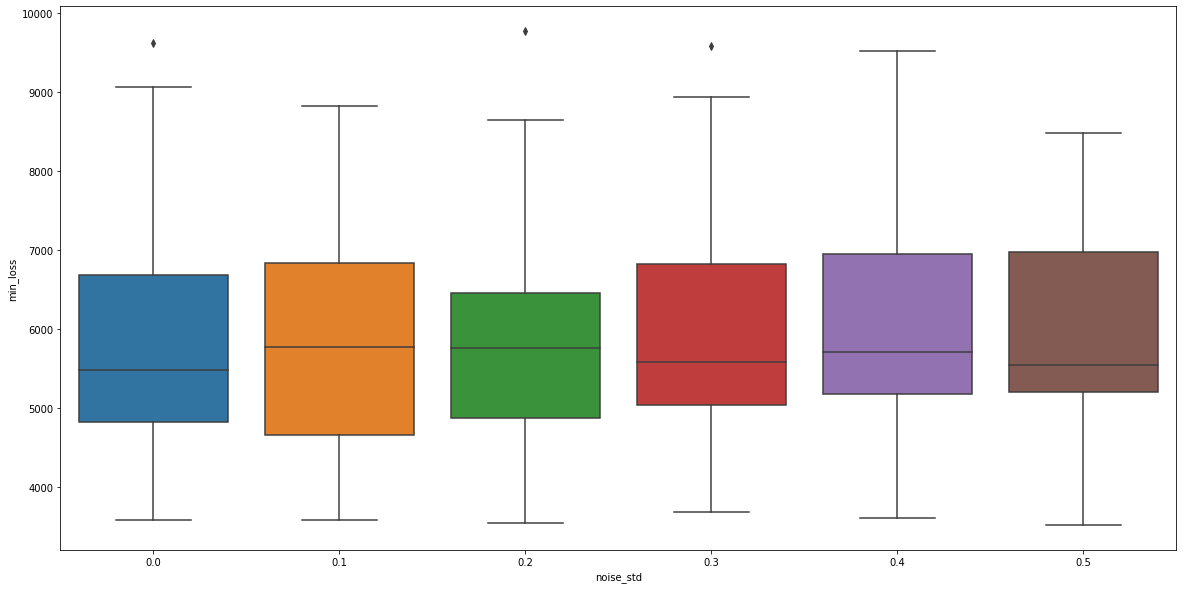

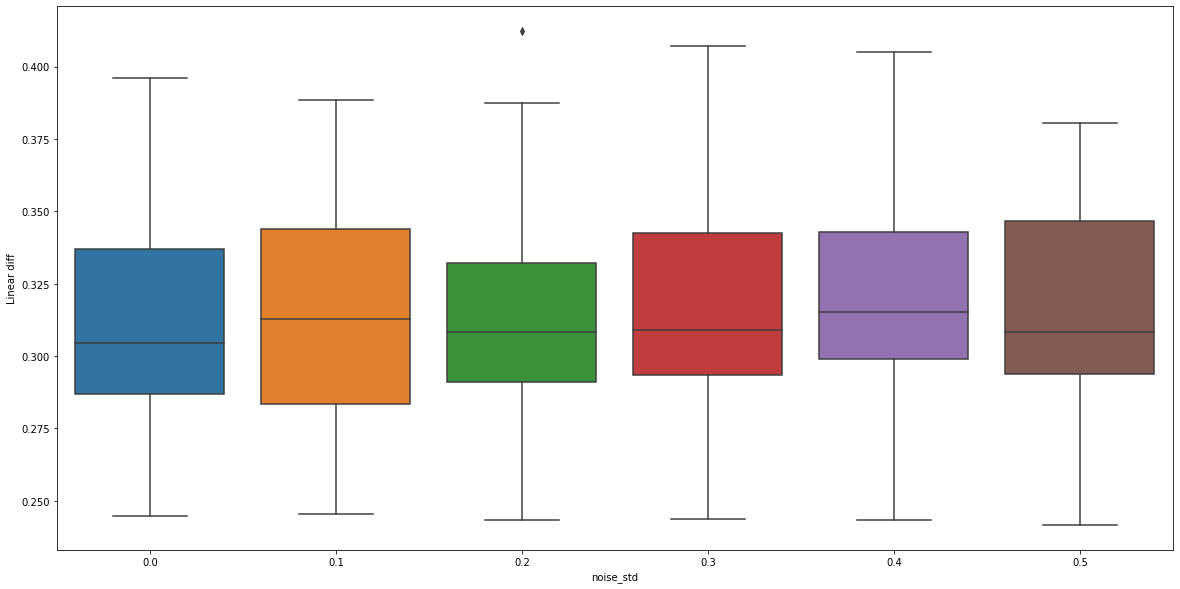

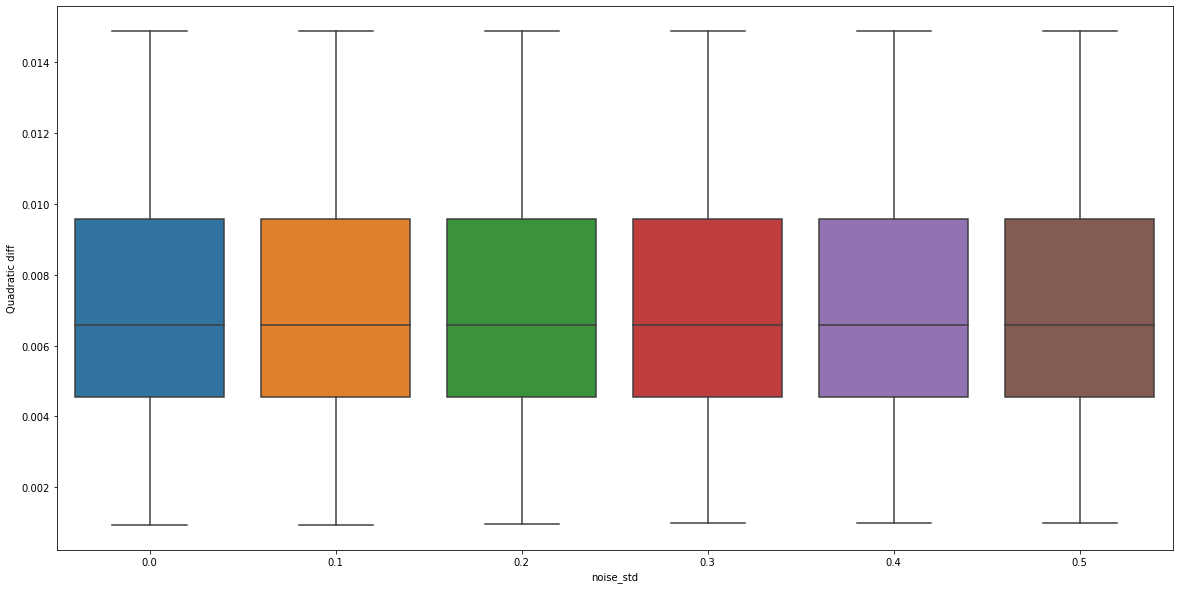

In [75]:
boxplot_feature(data=grid_df_pend, fixed_feat1='epoch', val_feat1=1000, fixed_feat2='batch', val_feat2=10, feat_x='noise_std', feat_y='min_loss');
boxplot_feature(data=grid_df_pend, fixed_feat1='epoch', val_feat1=1000, fixed_feat2='batch', val_feat2=10, feat_x='noise_std', feat_y='Linear diff');
boxplot_feature(data=grid_df_pend, fixed_feat1='epoch', val_feat1=1000, fixed_feat2='batch', val_feat2=10, feat_x='noise_std', feat_y='Quadratic diff')

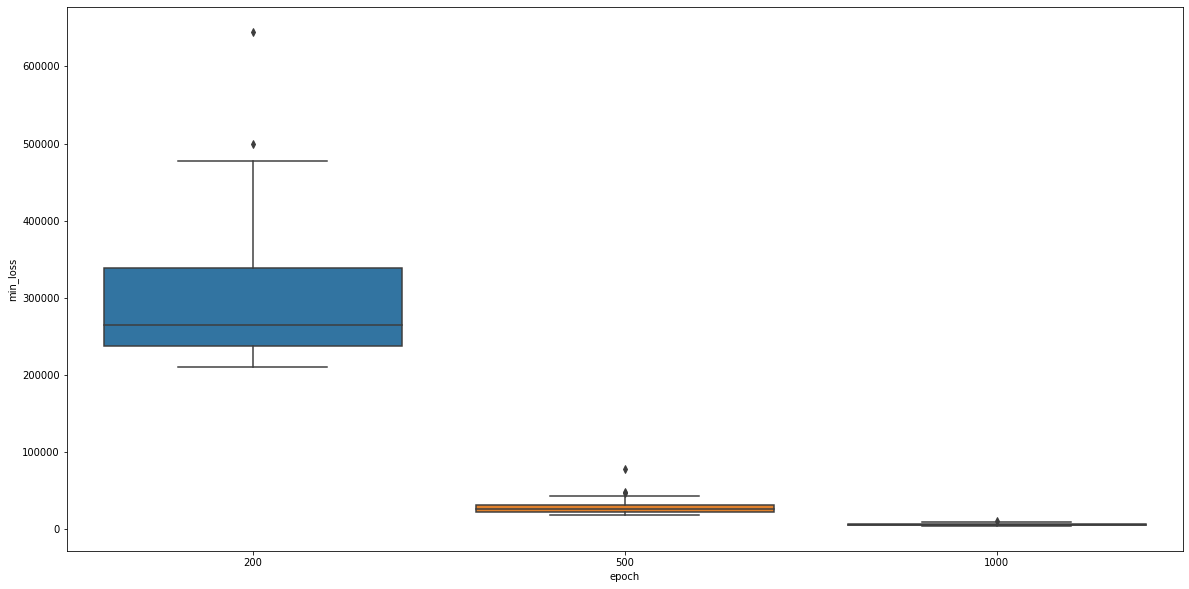

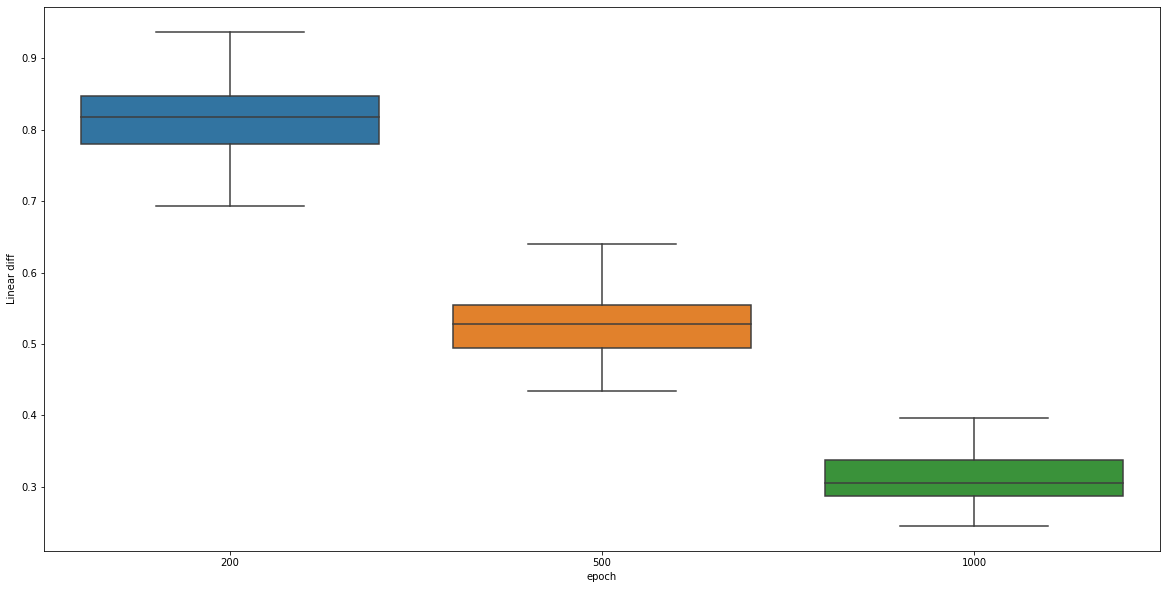

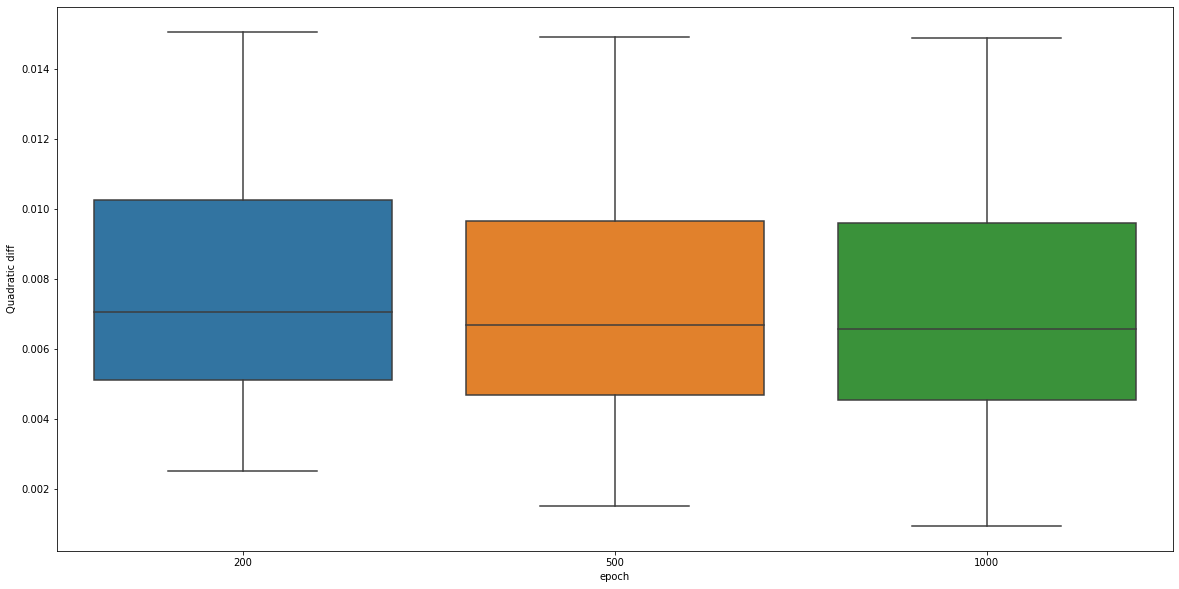

In [76]:
boxplot_feature(data=grid_df_pend, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='batch', val_feat2=10, feat_x='epoch', feat_y='min_loss');
boxplot_feature(data=grid_df_pend, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='batch', val_feat2=10, feat_x='epoch', feat_y='Linear diff');
boxplot_feature(data=grid_df_pend, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='batch', val_feat2=10, feat_x='epoch', feat_y='Quadratic diff')

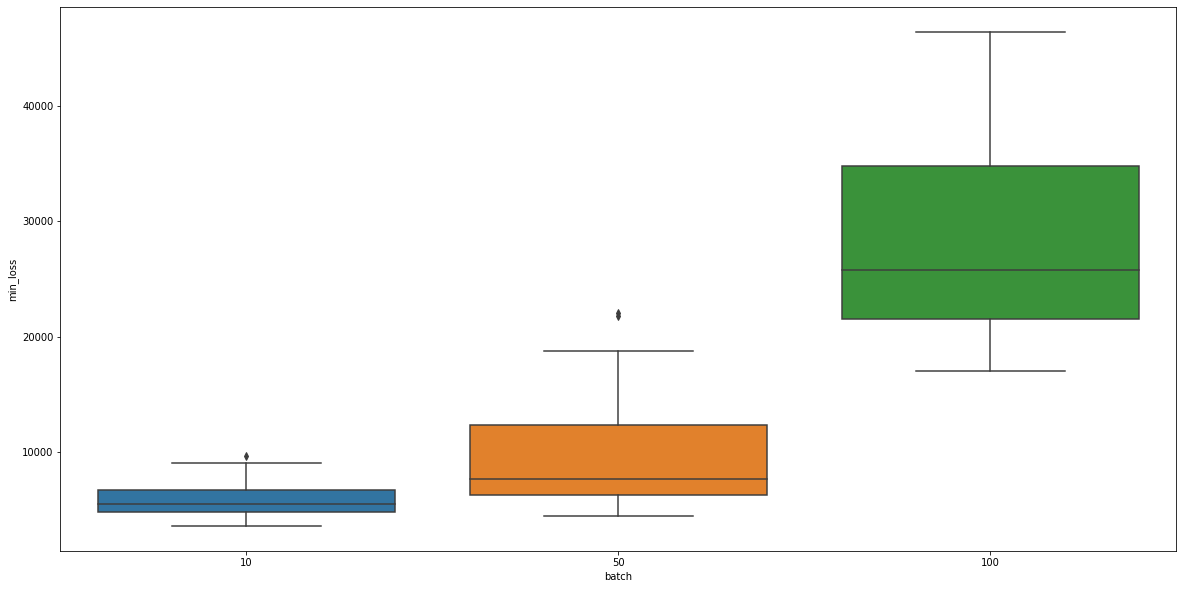

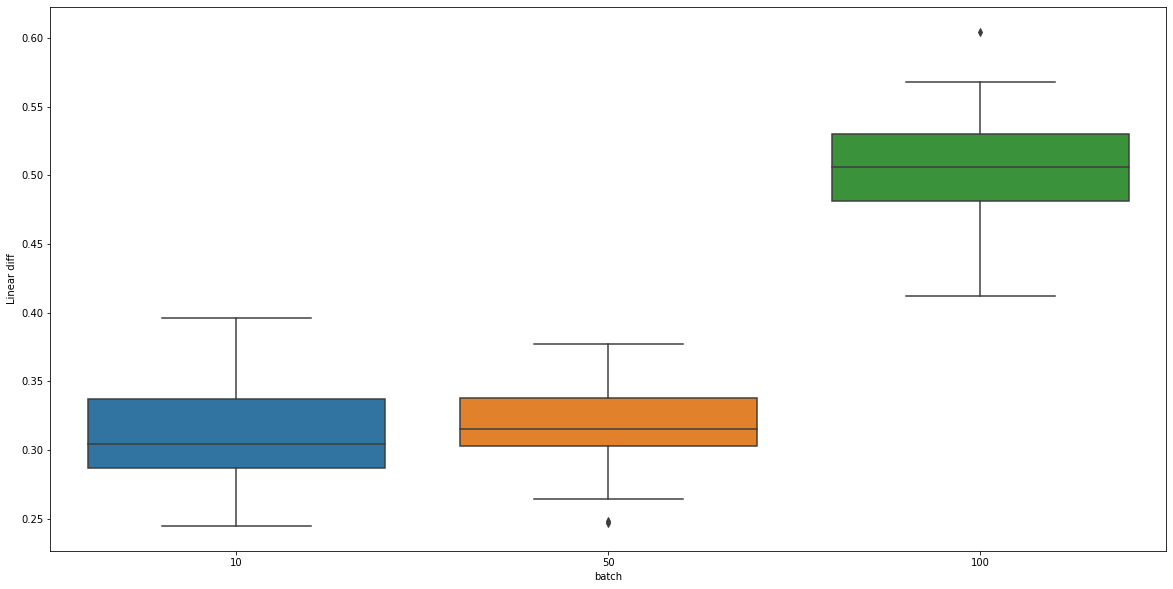

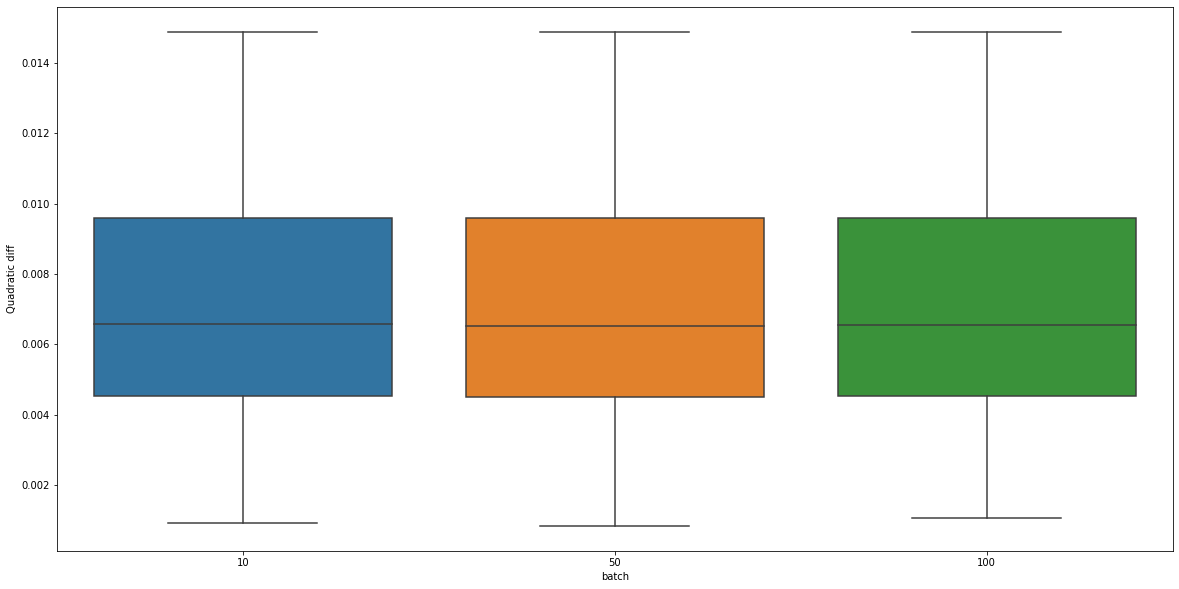

In [77]:
boxplot_feature(data=grid_df_pend, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='epoch', val_feat2=1000, feat_x='batch', feat_y='min_loss');
boxplot_feature(data=grid_df_pend, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='epoch', val_feat2=1000, feat_x='batch', feat_y='Linear diff');
boxplot_feature(data=grid_df_pend, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='epoch', val_feat2=1000, feat_x='batch', feat_y='Quadratic diff')

## Lorenz attractor

In [88]:
x = 0
y = 1
z = 1.05
sigma = 10
rho = 30
beta = 8/3
dt = 0.01

sol = [[x, y, z]]

train_x, train_y, H, B = generate_lorenz(sigma, rho, beta, sol)
print('Parameter:')
print(H)
print(B)
print('train_x size:', train_x.size())
print('train_y size:', train_y.size())

Parameter:
tensor([[0.9000, 0.1000, 0.0000],
        [0.3000, 0.9900, 0.0000],
        [0.0000, 0.0000, 0.9733]])
tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0000, -0.0100],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]],

        [[ 0.0000,  0.0100,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000]]])
train_x size: torch.Size([10000, 3])
train_y size: torch.Size([10000, 3])


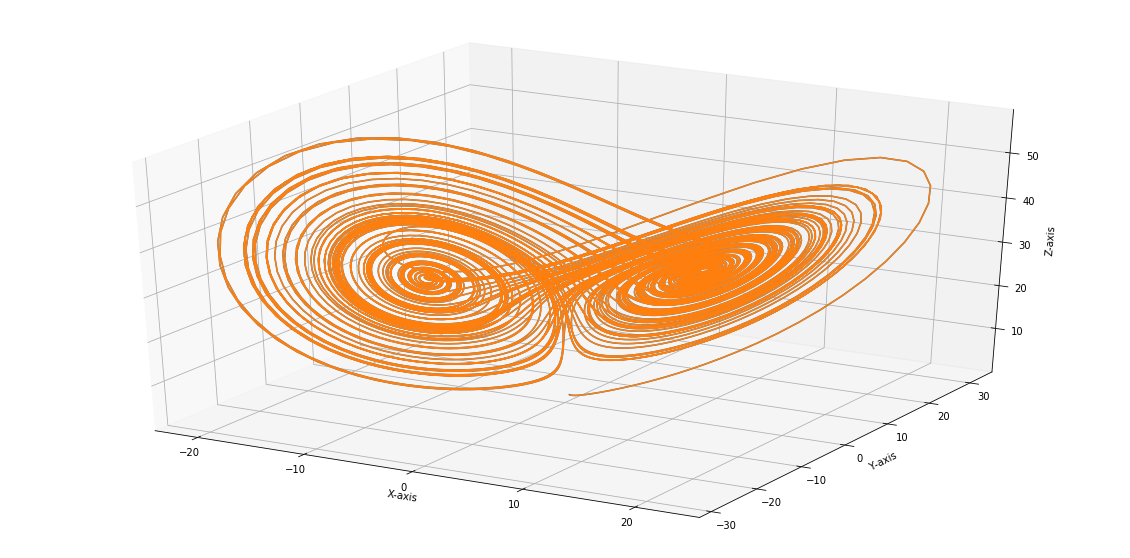

In [51]:
fig = plt.figure(figsize=(20,10))
ax = fig.gca(projection='3d')
ax.plot(train_x[:,0].numpy(), train_x[:,1].numpy(), train_x[:,2].numpy());
ax.plot(train_y[:,0].numpy(), train_y[:,1].numpy(), train_y[:,2].numpy())
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
plt.show()

In [85]:
print('Define variable')
x = 0
y = 1
z = 1.05
sigma = 10
rho = 30
beta = 8/3
dt = 0.01
T = 1000
z_dim = 3

sol = [[x, y, z]]

print('Genrate data')
train_x, train_y, H, B = generate_lorenz(sigma, rho, beta, sol, dt, T)

epoch = [200, 500, 1000]
batch = [10, 50, 100]
noise=[0.,0.1,0.2,0.3,0.4,0.5]
print('Fit model')
model = NNODEModel(3,3,3)

grid_val = grid_search(model, train_x, train_y, T, z_dim, H, B, 40, noise, epoch, batch)

print('---------------------------------')
print('save features:')
grid_df = pd.DataFrame(grid_val)
path_gen = '../gen_data/'
n_sim_str = '_1000'
data = 'lorenz_df'
grid_df.to_csv(path_gen + data + n_sim_str + '.csv')

Define variable
Genrate data
Fit model
start simulation
simulation: 1
simulation: 2
simulation: 3
simulation: 4
simulation: 5
simulation: 6
simulation: 7
simulation: 8
simulation: 9
simulation: 10
simulation: 11
simulation: 12
simulation: 13
simulation: 14
simulation: 15
simulation: 16
simulation: 17
simulation: 18
simulation: 19
simulation: 20
simulation: 21
simulation: 22
simulation: 23
simulation: 24
simulation: 25
simulation: 26
simulation: 27
simulation: 28
simulation: 29
simulation: 30
simulation: 31
simulation: 32
simulation: 33
simulation: 34
simulation: 35
simulation: 36
simulation: 37
simulation: 38
simulation: 39
simulation: 40
end simulation
---------------------------------
save features:


In [86]:
grid_df_lorenz_1000 = pd.read_csv(path_gen + 'lorenz_df_1000.csv')
grid_df_lorenz_1000

,Unnamed: 0,noise_std,epoch,batch,min_loss,Linear diff,Quadratic diff,Linear,Quadratic
0,0,0.0,200,10,415.235054,33.025593,0.133424,[[ 0.2660012 0.34516168 0.00481499]\n [ 0.3...,[[[-7.09583797e-03 7.83991534e-03 8.44447222...
1,1,0.0,200,50,66.232870,32.987263,0.116629,[[ 0.34060892 0.4269496 0.06105396]\n [ 0.3...,[[[-0.00148063 0.00482754 0.00431253]\n [-0...
2,2,0.0,200,100,41.975578,33.012535,0.115472,[[ 0.33691448 0.36362654 0.06322888]\n [ 0.3...,[[[-0.00131757 0.00499924 0.00434631]\n [-0...
3,3,0.0,500,10,146.536859,33.020958,0.114964,[[ 0.42286003 0.4058006 0.057808 ]\n [ 0.3...,[[[-0.00100963 0.00493515 0.0034609 ]\n [-0...
4,4,0.0,500,50,33.612342,32.952980,0.125419,[[ 0.4109212 0.5945694 0.05995847]\n [ 0.3...,[[[-0.00160085 0.00515679 0.00358583]\n [-0...
...,...,...,...,...,...,...,...,...,...
2155,2155,0.5,500,50,36.860352,33.004920,0.117391,[[ 0.44619182 0.5621652 0.05610231]\n [ 0.3...,[[[-0.00057928 -0.00202912 0.00598058]\n [ 0...
2156,2156,0.5,500,100,23.821163,33.006050,0.121696,[[ 0.43050918 0.53700244 0.05877204]\n [ 0.3...,[[[-1.1153529e-04 -2.0302050e-03 6.1354749e-0...
2157,2157,0.5,1000,10,65.516961,33.094006,0.079342,[[ 0.5034227 0.44366065 0.06777187]\n [ 0.3...,[[[-0.00109634 -0.00182253 0.00533386]\n [ 0...
2158,2158,0.5,1000,50,22.808503,33.038460,0.104724,[[ 0.5035903 0.5947599 0.06572342]\n [ 0.3...,[[[-1.1299325e-03 -1.8228509e-03 5.3273714e-0...


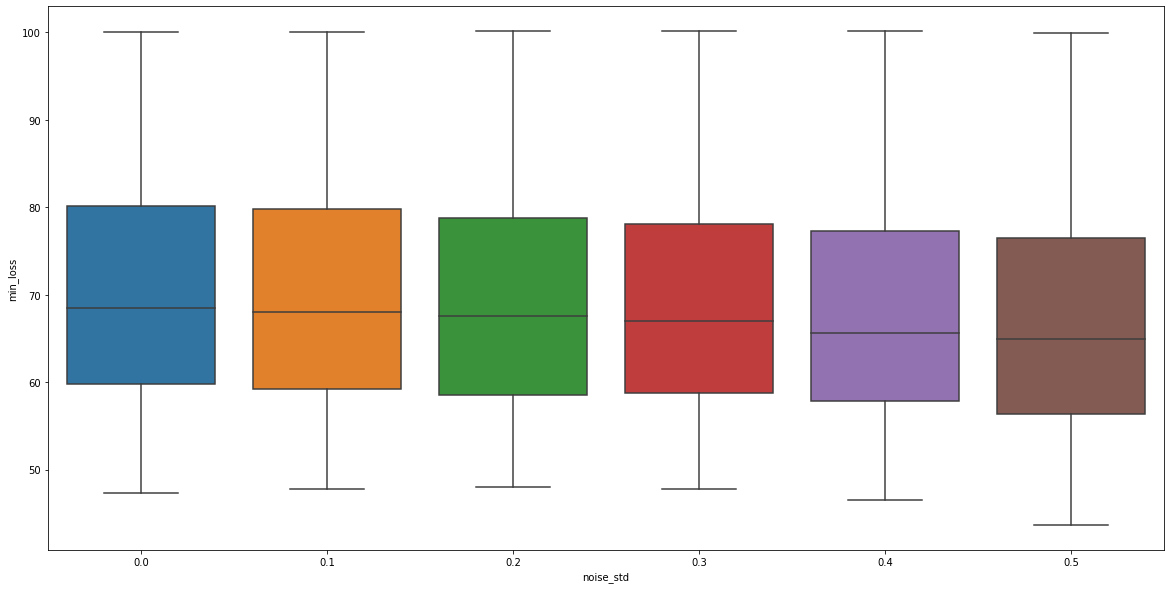

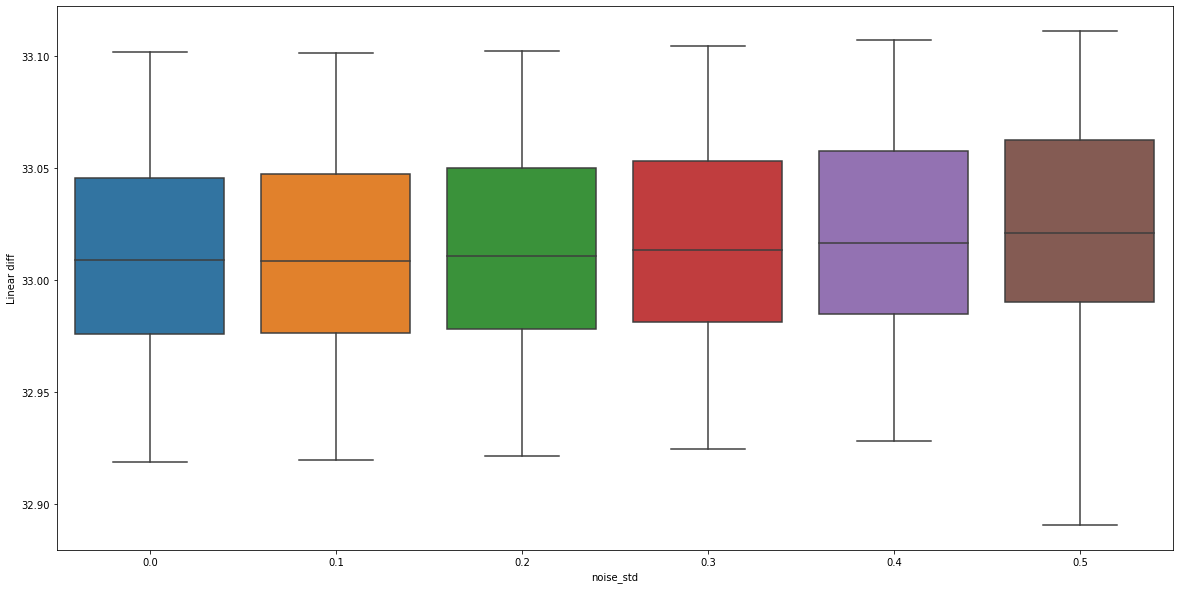

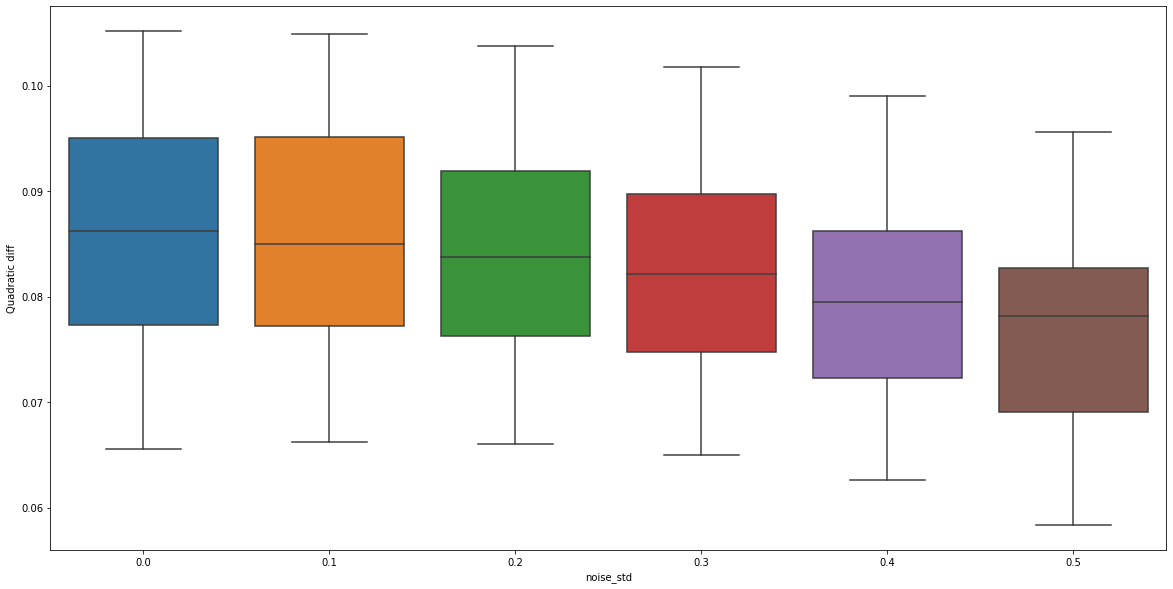

In [89]:
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='epoch', val_feat1=1000, fixed_feat2='batch', val_feat2=10, feat_x='noise_std', feat_y='min_loss');
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='epoch', val_feat1=1000, fixed_feat2='batch', val_feat2=10, feat_x='noise_std', feat_y='Linear diff');
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='epoch', val_feat1=1000, fixed_feat2='batch', val_feat2=10, feat_x='noise_std', feat_y='Quadratic diff')

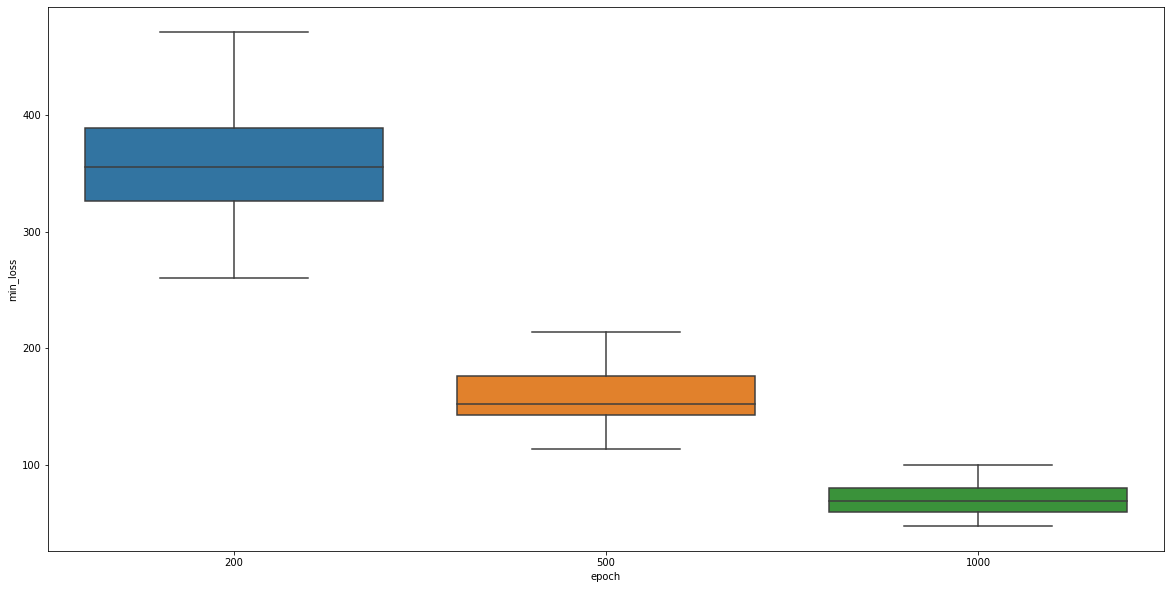

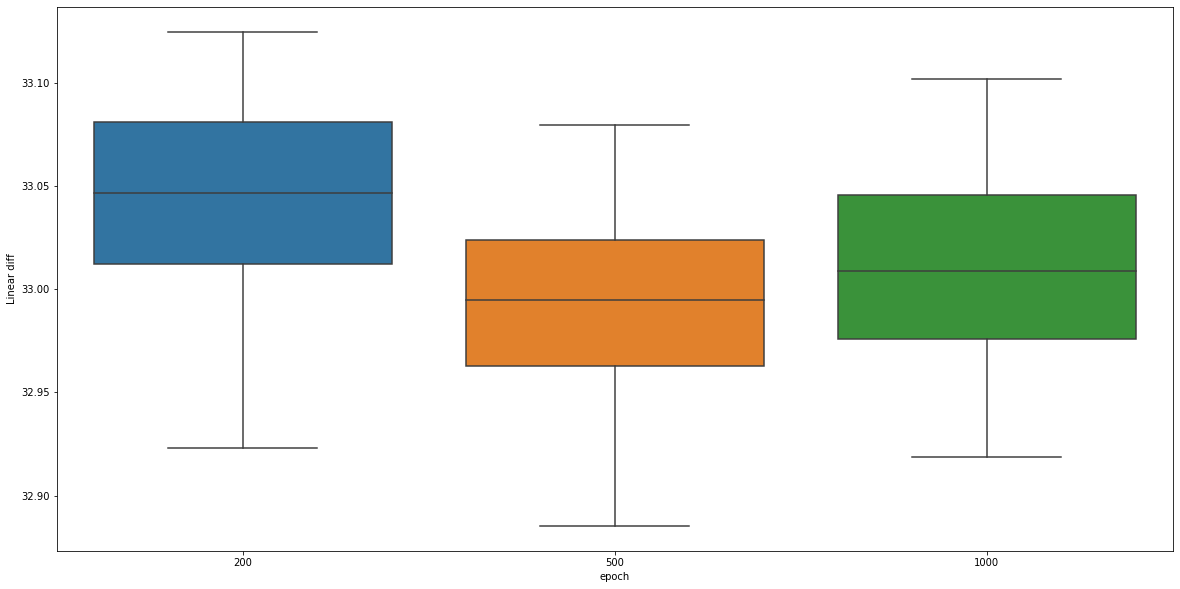

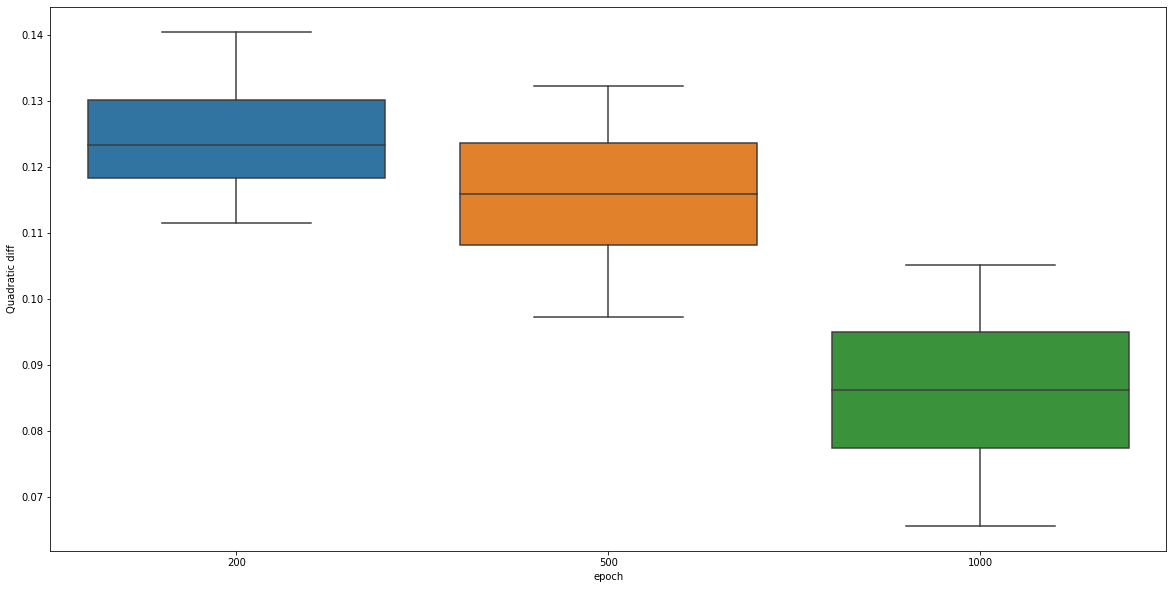

In [90]:
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='batch', val_feat2=10, feat_x='epoch', feat_y='min_loss');
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='batch', val_feat2=10, feat_x='epoch', feat_y='Linear diff');
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='batch', val_feat2=10, feat_x='epoch', feat_y='Quadratic diff')

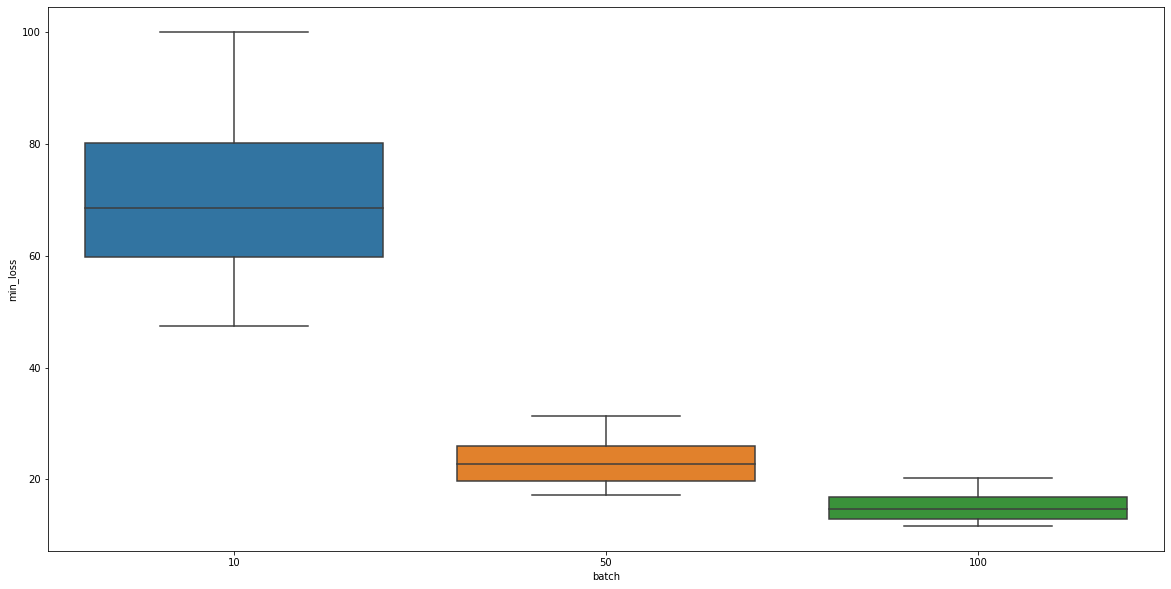

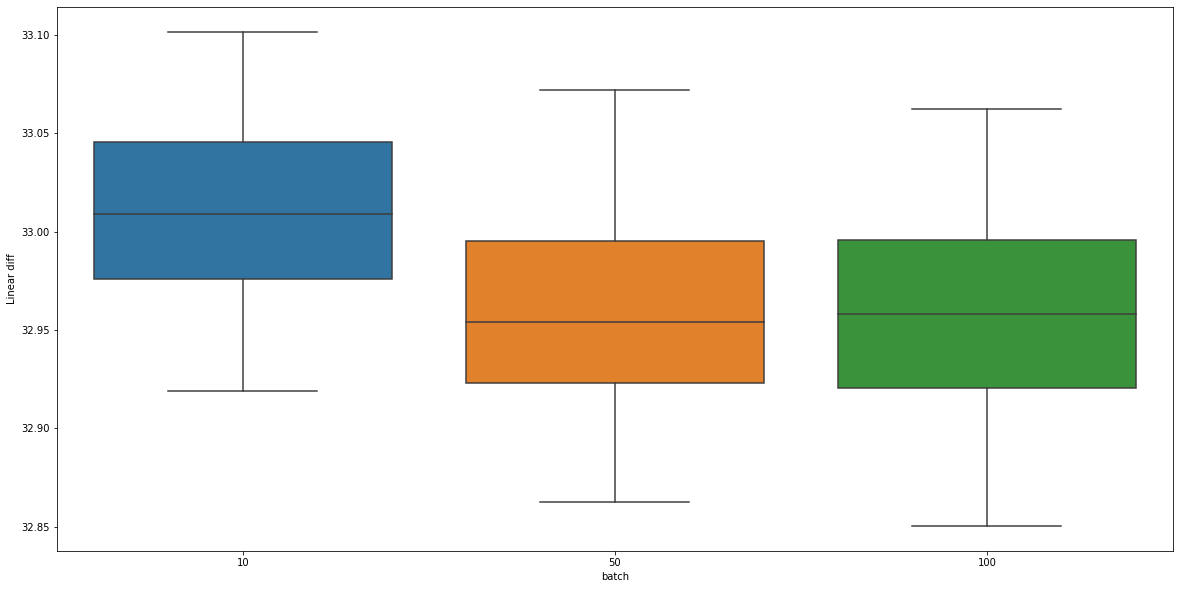

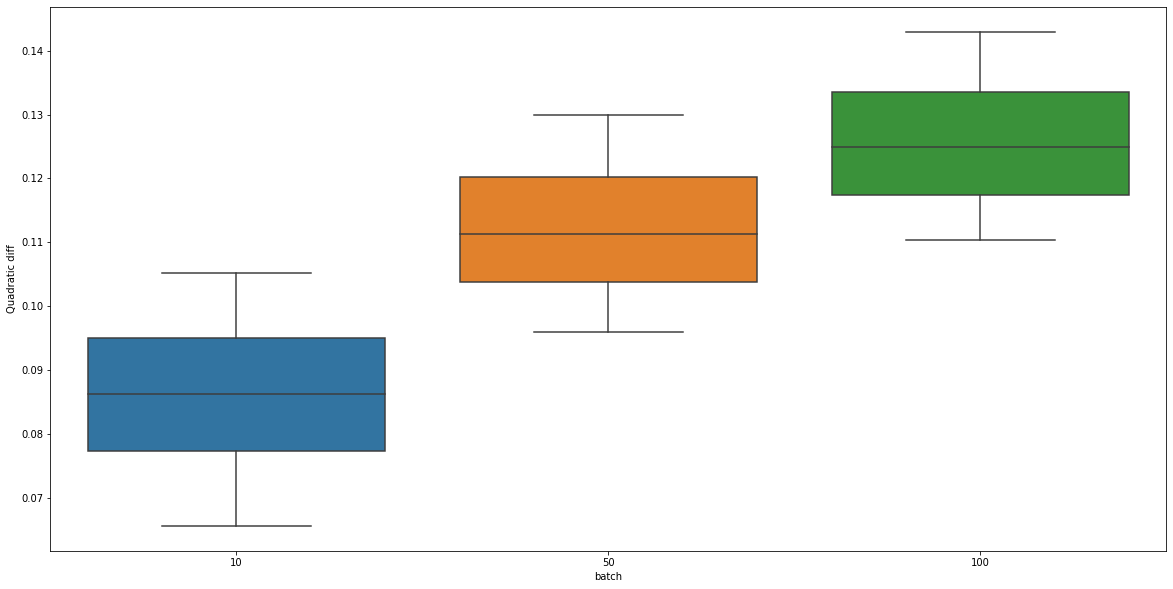

In [91]:
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='epoch', val_feat2=1000, feat_x='batch', feat_y='min_loss');
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='epoch', val_feat2=1000, feat_x='batch', feat_y='Linear diff');
boxplot_feature(data=grid_df_lorenz_1000, fixed_feat1='noise_std', val_feat1=0, fixed_feat2='epoch', val_feat2=1000, feat_x='batch', feat_y='Quadratic diff')

## Explosion point for Pendulum
## No noise

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[0.0564, 0.0392],
        [0.0416, 0.0620]], requires_grad=True), Parameter containing:
tensor([[[ 0.0099,  0.0087],
         [ 0.0026, -0.0056]],

        [[-0.0084, -0.0092],
         [ 0.0063,  0.0036]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9382,  0.5438],
        [-0.0117,  0.9699]], requires_grad=True), Parameter containing:
tensor([[[-2.8337e-02,  3.4671e-03],
         [-2.6343e-03, -2.8776e-05]],

        [[-6.7539e-02, -3.4164e-03],
         [ 1.2165e-02,  1.1290e-03]]], requires_grad=True)]


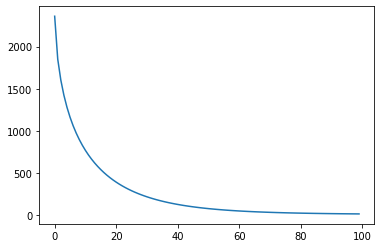

In [13]:
#without noise
print('Initial matrix H:')
print(H)

model = NNODEModel(2,2,2)

train_loss, lin_weight, nl_weight = training_session(model, train_x, train_y)

In [16]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

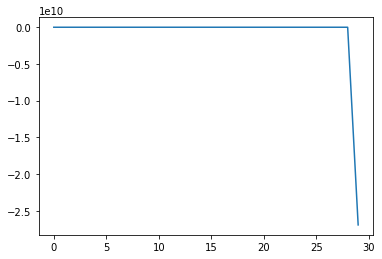

In [21]:
plt.plot(pred[0:30,0]);
plt.show()

Reconstruction of the model (without noise):

Explosion time point from 0 to 100: $t=30$

## Noise with std = 0.1

In [107]:
#with noise
print('Initial matrix H:')
print(H)

model = NNODEModel(2,2,2)
train_loss_noise, lin_weight, nl_weight = training_session(model, train_x_noise, train_y_noise)

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])


In [33]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

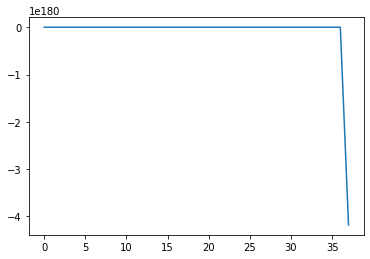

In [37]:
plt.plot(pred[0:40,0]);
plt.show()

Reconstruction of the model (noise with std=0.1):

Explosion time point from 0 to 100: $t=40$

## Noise with std=0.2

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0347, -0.0858],
        [-0.0070, -0.0616]], requires_grad=True), Parameter containing:
tensor([[[ 0.0020,  0.0007],
         [-0.0073, -0.0066]],

        [[ 0.0083,  0.0056],
         [-0.0087,  0.0043]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9075,  0.4135],
        [-0.0122,  0.9329]], requires_grad=True), Parameter containing:
tensor([[[-3.8746e-02,  4.8056e-03],
         [-3.2227e-03, -4.1064e-05]],

        [[-6.4993e-02,  1.1607e-02],
         [-2.6569e-03,  2.3450e-03]]], requires_grad=True)]


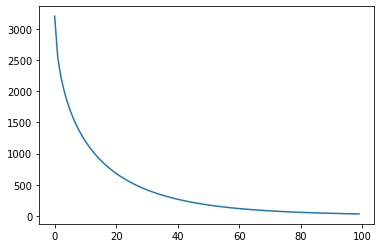

In [38]:
#noise with sigma=0.2
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise2, lin_weight, nl_weight = training_session(model, train_x_noise2, train_y_noise2)

In [39]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

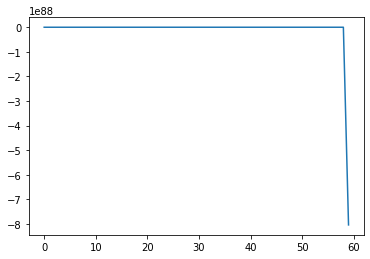

In [47]:
plt.plot(pred[0:60,0]);
plt.show()

Reconstruction of the model (noise with std=0.2):

Explosion time point from 0 to 100: $t=60$

## Noise with std = 0.3

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0856,  0.0549],
        [ 0.0028, -0.0647]], requires_grad=True), Parameter containing:
tensor([[[ 0.0052,  0.0025],
         [-0.0041, -0.0037]],

        [[-0.0084,  0.0052],
         [ 0.0034, -0.0087]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.8860,  0.5007],
        [-0.0126,  0.9335]], requires_grad=True), Parameter containing:
tensor([[[-4.5280e-02,  4.3772e-03],
         [-2.1935e-03, -4.3616e-05]],

        [[-6.1820e-02,  3.9969e-03],
         [ 2.2156e-03,  2.3468e-03]]], requires_grad=True)]


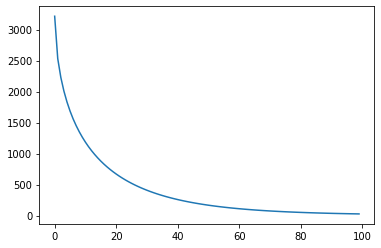

In [48]:
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise3, lin_weight, nl_weight = training_session(model, train_x_noise3, train_y_noise3)

In [49]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

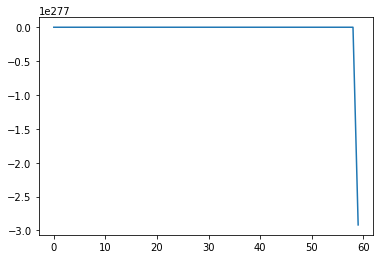

In [55]:
plt.plot(pred[0:60,0]);
plt.show()

Reconstruction of the model (noise with std=0.3):

Explosion time point from 0 to 100: $t=60$

## Noise with std=0.4

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[-0.0212,  0.0933],
        [-0.0319,  0.0152]], requires_grad=True), Parameter containing:
tensor([[[-0.0081,  0.0032],
         [-0.0063, -0.0052]],

        [[-0.0089,  0.0036],
         [-0.0008,  0.0091]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9122,  0.5548],
        [-0.0122,  0.9576]], requires_grad=True), Parameter containing:
tensor([[[-3.7630e-02,  5.4898e-03],
         [-4.0485e-03, -3.8616e-05]],

        [[-6.4520e-02,  5.7151e-03],
         [ 1.2417e-03,  1.5513e-03]]], requires_grad=True)]


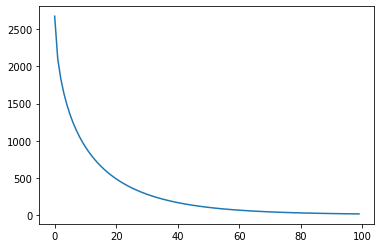

In [58]:
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise4, lin_weight, nl_weight = training_session(model, train_x_noise4, train_y_noise4)

In [59]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

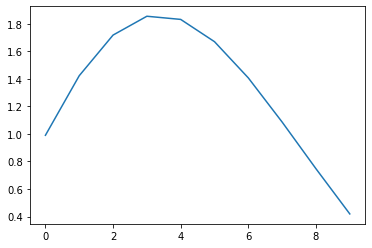

In [67]:
plt.plot(pred[0:10,0]);
plt.show()

Reconstruction of the model (noise with std=0.4):

Explosion time point from 0 to 100: $t=40$

## Noise with std=0.5

Initial matrix H:
tensor([[ 1.0000,  1.0000],
        [-0.0100,  1.0000]])
Initial weigths of the matrix:
[Parameter containing:
tensor([[0.0790, 0.0403],
        [0.0514, 0.0702]], requires_grad=True), Parameter containing:
tensor([[[-0.0038,  0.0022],
         [ 0.0064, -0.0061]],

        [[ 0.0072, -0.0093],
         [ 0.0021,  0.0063]]], requires_grad=True)]
Final weigths of the matrix:
[Parameter containing:
tensor([[ 0.9445,  0.5494],
        [-0.0115,  0.9716]], requires_grad=True), Parameter containing:
tensor([[[-2.6362e-02, -1.7980e-03],
         [ 2.4831e-03, -2.2506e-05]],

        [[-6.0788e-02, -1.3039e-03],
         [ 1.0071e-02,  1.0461e-03]]], requires_grad=True)]


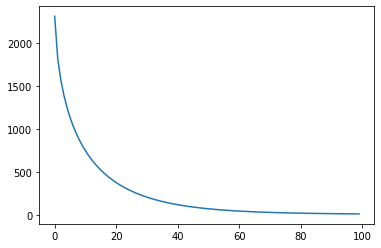

In [68]:
print('Initial matrix H:')
print(H)
model =  NNODEModel(2,2,2)
train_loss_noise5, lin_weight, nl_weight = training_session(model, train_x_noise5, train_y_noise5)

In [69]:
#Reconstruction of the data
sol = [[0.99,1]]
T = 100
pred = prediction(lin_weight, nl_weight, sol, T)

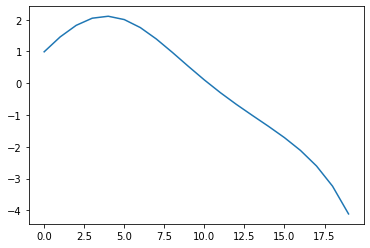

In [72]:
plt.plot(pred[0:20,0]);
plt.show()

Reconstruction of the model (noise with std=0.5):

Explosion time point from 0 to 100: $t=30$

# Analysis of the model

In [73]:
print('train_loss min:', train_loss[99])
print('train_loss_noise min:', train_loss_noise[99])
print('train_loss_noise2 min:', train_loss_noise2[99])
print('train_loss_noise3 min:', train_loss_noise3[99])
print('train_loss_noise4 min:', train_loss_noise4[99])
print('train_loss_noise5 min:', train_loss_noise5[99])

train_loss min: 12.689681535179261
train_loss_noise min: 20.926694257221243
train_loss_noise2 min: 32.06298375350889
train_loss_noise3 min: 27.950475619843928
train_loss_noise4 min: 15.853154807322426
train_loss_noise5 min: 12.09131604898721


# The test

29.11.2019:

data = pendulum

Explosion time:

std = 0, t=30

std = 0.1, t=40

std = 0.2, t=60

std = 0.3, t=60

std = 0.4, t=40

std = 0.5, t=30

--------------------------------------------------------------------------

# Real Data

In [18]:
data_path = '../data/'
data = pd.read_parquet(data_path+'SPY_hourly.parquet')

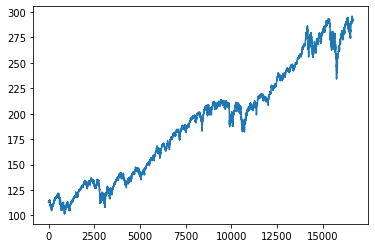

In [19]:
plt.plot(data.values)
plt.show()

In [20]:
spy=data.values.reshape((1,-1))[0]